# This notebook makes the Pseudobulks from processed single-cell data and formats relevant metadata

In [9]:
import sys
import pathlib
import subprocess
import pickle

import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Import buddi preprocessing module

In [10]:
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)
BUDDI_PATH = REPO_ROOT / "src"

sys.path.insert(0, str(BUDDI_PATH))

from buddi_v2 import preprocessing
from buddi_v2.preprocessing import utils
from buddi_v2.preprocessing import generate_pseudo_bulks

In [11]:
DATA_NAME = 'liver'

CELL_TYPE_COL = 'scpred_CellType'
CELL_TYPE_COL_SOURCE = 'names_merged'
SAMPLE_ID_COL = 'sample_id'
SAMPLE_ID_COL_SOURCE = 'mouse.id'
STIM_COL = 'stim'
STIM_COL_SOURCE = 'sex'
def get_stim_id(in_str):
    out_str = "female"
    if in_str == "male":
        out_str = "male"
           
    return(out_str)

GENE_ID_COL = 'gene_ids'
DATASPLIT_COL = 'isTraining'
DATASPLIT_SEED = 42

## Define Paths

In [12]:
## Input data path
DATA_PATH = pathlib.Path('.').absolute() / 'example_data'
assert DATA_PATH.exists()
SC_DATA_FILE = DATA_PATH / 'processed_sc_liver' / 'liver_droplet_processed.h5ad'
assert SC_DATA_FILE.exists()

## Cibersortx
CIBERSORTX_SIG_GENE_FILE = DATA_PATH / 'cibersort_liver' /\
    'CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists()

## Output path
PREPROCESS_OUTPUT_PATH = pathlib.Path('.').absolute() / 'example_data' / 'preprocessed_data'
assert PREPROCESS_OUTPUT_PATH.exists(), 'Please create the output directory "preprocessed_data" first'
PREPROCESS_SC_AUGMENTED_OUTPUT_PATH = PREPROCESS_OUTPUT_PATH / 'sc_augmented'
PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.mkdir(exist_ok=True)

## Load Processed Single Cell Data

In [13]:
adata = sc.read_h5ad(SC_DATA_FILE)
adata.var_names_make_unique()

if CELL_TYPE_COL_SOURCE not in adata.obs.columns:
    raise ValueError(f"Column {CELL_TYPE_COL_SOURCE} not found in the AnnData object.")
else:
    adata.obs[CELL_TYPE_COL] = adata.obs[CELL_TYPE_COL_SOURCE].tolist()
if SAMPLE_ID_COL_SOURCE not in adata.obs.columns:
    raise ValueError(f"Column {SAMPLE_ID_COL_SOURCE} not found in the AnnData object.")
else:
    adata.obs[SAMPLE_ID_COL] = adata.obs[SAMPLE_ID_COL_SOURCE].tolist()
if STIM_COL_SOURCE not in adata.obs.columns:
    raise ValueError(f"Column {STIM_COL_SOURCE} not found in the AnnData object.")
else:
    adata.obs[STIM_COL] = [get_stim_id(str(x)) for x in adata.obs[STIM_COL_SOURCE].tolist()]

adata.obs[DATASPLIT_COL] = "Train"
stim_idx = np.where(adata.obs[STIM_COL] == "female")[0]
adata.obs.loc[adata.obs.index[stim_idx], DATASPLIT_COL] = "Test"

adata.var[GENE_ID_COL] = adata.var.index.tolist()

### Sample vs Stim Contingency Table

In [14]:
ct = pd.crosstab(adata.obs[SAMPLE_ID_COL], adata.obs[STIM_COL])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

stim       female  male
sample_id              
18-F-51       698     0
30-M-5          0   362


### Sample vs Cell Type Contingency Table

In [15]:
ct = pd.crosstab(adata.obs[CELL_TYPE_COL], adata.obs[SAMPLE_ID_COL])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

sample_id                    18-F-51  30-M-5
scpred_CellType                             
NK                               109      88
b_cell                            24      73
hepatic_sinusoid                  27      80
hepatic_stellate                   2       5
hepatocyte                       267      29
kupffer                          221      44
myeloid_leukocyte                 40      34
plasmacytoid_dendritic_cell        8       9


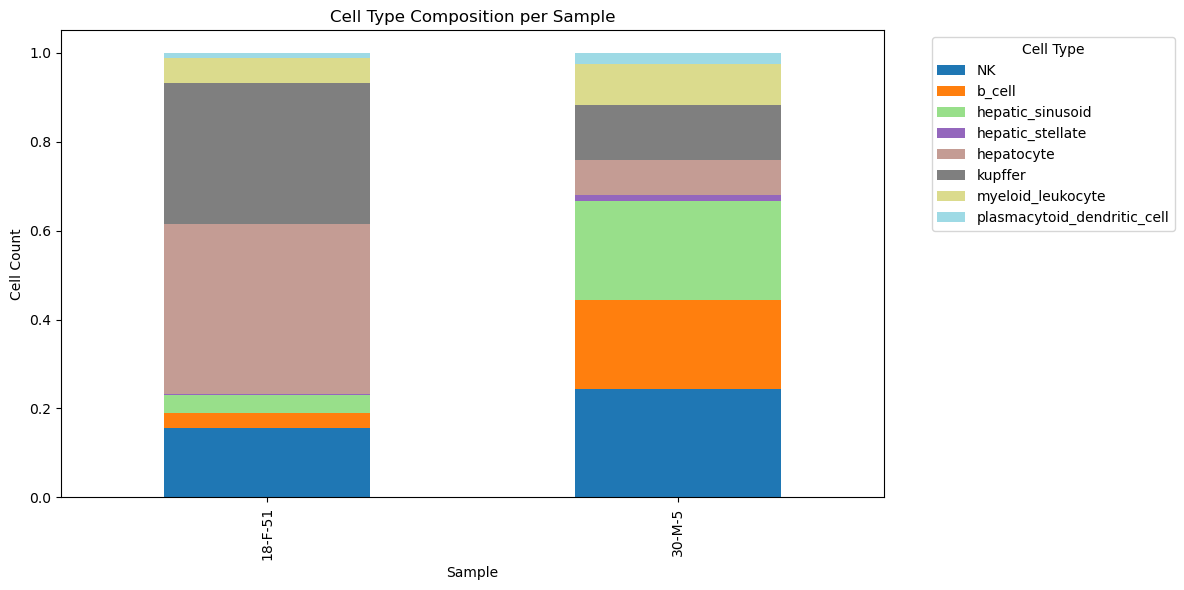

In [16]:
count_df = adata.obs.groupby([SAMPLE_ID_COL, CELL_TYPE_COL]).size().reset_index(name='count')
pivot_df = count_df.pivot(index=SAMPLE_ID_COL, columns=CELL_TYPE_COL, values='count').fillna(0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20', ax=ax)

plt.xlabel('Sample')
plt.ylabel('Cell Count')
plt.title('Cell Type Composition per Sample')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Augment sc Data

### Load Cibersortx signature genes

In [6]:
cibersortx_sig_df = pd.read_csv(CIBERSORTX_SIG_GENE_FILE, sep='\t', header=0)
cibersortx_sig_genes = cibersortx_sig_df['NAME'].values.tolist()
print(f"{len(cibersortx_sig_genes)} signature genes from CIBERSORTx")

2194 signature genes from CIBERSORTx


### Output Gene ids

In [7]:
gene_out_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_genes.pkl'
gene_ids = adata.var[GENE_ID_COL]
pickle.dump(gene_ids, open( gene_out_file, "wb" ))

### Make Pseudo-bulks

In [8]:
ADD_PER_CELL_TYPE_NOISE = False
N_CELLS_PER_PSEUDO_BULK = 5_000
N_PSEUDO_BULKS_PER_CONDITION = 1_000

gene_ids = adata.var[GENE_ID_COL]
samples = adata.obs[SAMPLE_ID_COL].unique()
stims = adata.obs[STIM_COL].unique()

cell_types = adata.obs[CELL_TYPE_COL].unique() # Global cell types
cell_order = sorted(cell_types) # order proportion columns

datasplits = adata.obs[DATASPLIT_COL].unique()

n_samples = len(samples)
n_genes = len(gene_ids)
n_cell_types = len(cell_order)

# Define cell-type level noise for the generated pseudo-bulk profiles
if ADD_PER_CELL_TYPE_NOISE:
    # this produces a list of numpy arrays, each of length n_genes
    # to reflect the expression noise associated with each specific cell type
    per_cell_type_noise = [
        np.random.lognormal(0, 1, n_genes) for i in range(n_cell_types)]
else:
    per_cell_type_noise = None

In [9]:
# Generate pseudo-bulk profiles grouping by sample_id and stim
for _sample in samples:
    for _stim in stims:
        for _datasplit in datasplits:

            print(f"Generating pseudo-bulk profiles for sample {_sample}, stim {_stim}, and datasplit {_datasplit} ...")
            
            ## Subset adata to the current sample, stim and train/test split
            subset_idx = np.where(
                np.logical_and.reduce((
                    adata.obs[SAMPLE_ID_COL] == _sample, 
                    adata.obs[STIM_COL] == _stim,
                    adata.obs[DATASPLIT_COL] == _datasplit,
                ))
            )[0]
            
            if len(subset_idx) == 0:
                continue
            subset_adata = adata[subset_idx, :]

            ## Cell type that is present in the subset, will inform the 
            ## down stream workflow of potential missing cell types to skip
            present_cell_types = subset_adata.obs[CELL_TYPE_COL].unique().tolist()

            ## Subset the cell_df to the present cell types
            cell_df = preprocessing.utils.subset_adata_by_cell_type(
                subset_adata, 
                cell_type_col=CELL_TYPE_COL,
                cell_order=cell_order
            )

            print(">Generating random prop pseudo-bulk profiles ...")

            random_count_df = preprocessing.utils.generate_log_normal_counts(
                cell_order=cell_order, 
                num_cells=N_CELLS_PER_PSEUDO_BULK, 
                num_samples=N_PSEUDO_BULKS_PER_CONDITION,
                present_cell_types=present_cell_types
            )
            random_props_df = preprocessing.utils.generate_prop_from_counts(
                random_count_df,
            )
            random_pseudobulk_df = preprocessing.generate_pseudo_bulks.generate_pseudo_bulk_from_counts(
                in_adata=subset_adata,
                cell_df=cell_df,
                count_df=random_count_df,
                cell_noise=per_cell_type_noise,
                use_sample_noise=False
            )
            random_pseudobulk_metadata_df = pd.DataFrame(
                data = {
                    SAMPLE_ID_COL: [_sample]*N_PSEUDO_BULKS_PER_CONDITION,
                    STIM_COL: [_stim]*N_PSEUDO_BULKS_PER_CONDITION,
                    'cell_prop_type': ['random']*N_PSEUDO_BULKS_PER_CONDITION,
                    'cell_type': ['random']*N_PSEUDO_BULKS_PER_CONDITION,
                    'samp_type': ['sc_ref']*N_PSEUDO_BULKS_PER_CONDITION,
                }
            )

            print(">Generating single cell dominant pseudo-bulk profiles ...")

            single_cell_props_df, single_cell_metadata = preprocessing.utils.generate_single_celltype_dominant_props(
                num_samp=100,
                cell_order=cell_order,
                present_cell_types=present_cell_types,
                return_metadata=True
            )
            single_cell_counts_df = preprocessing.utils.generate_counts_from_props(
                single_cell_props_df,
                num_cells=N_CELLS_PER_PSEUDO_BULK
            )
            single_cell_pseudobulk_df = preprocessing.generate_pseudo_bulks.generate_pseudo_bulk_from_counts(
                in_adata=subset_adata,
                cell_df=cell_df,
                count_df=single_cell_counts_df,
                cell_noise=per_cell_type_noise,
                use_sample_noise=False
            )
            n_single_celltype_pbs = len(single_cell_pseudobulk_df)
            single_cell_metadata_df = pd.DataFrame(
                data = {
                    SAMPLE_ID_COL: [_sample]*n_single_celltype_pbs,
                    STIM_COL: [_stim]*n_single_celltype_pbs,
                    'cell_prop_type': ['single_celltype']*n_single_celltype_pbs,
                    'cell_type': single_cell_metadata,
                    'samp_type': ['sc_ref']*n_single_celltype_pbs,
                }
            )

            print('>Concatenating the two types of pseudo-bulk profiles ...')
            props_df = pd.concat([random_props_df, single_cell_props_df])
            pseudobulk_df = pd.concat([random_pseudobulk_df, single_cell_pseudobulk_df])

            metadata_df = pd.concat(
                [random_pseudobulk_metadata_df, single_cell_metadata_df]
            )
            
            print(">Writing the pseudo-bulk profiles ...")
            pseudobulk_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_{_sample}_{_stim}_{_datasplit}_pseudo_splits.pkl'
            prop_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_{_sample}_{_stim}_{_datasplit}_prop_splits.pkl'
            meta_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_{_sample}_{_stim}_{_datasplit}_meta_splits.pkl'

            pickle.dump( props_df, open( prop_file, "wb" ) )
            pickle.dump( pseudobulk_df, open( pseudobulk_file, "wb" ) )
            pickle.dump( metadata_df, open( meta_file, "wb" ) )

            print(f"Done for sample {_sample}, stim {_stim}, and datasplit {_datasplit}\n")

Generating pseudo-bulk profiles for sample 18-F-51, stim female, and datasplit Test ...
>Generating random prop pseudo-bulk profiles ...


100%|██████████| 1000/1000 [00:20<00:00, 48.24it/s]


>Generating single cell dominant pseudo-bulk profiles ...


100%|██████████| 800/800 [00:17<00:00, 45.43it/s]


>Concatenating the two types of pseudo-bulk profiles ...
>Writing the pseudo-bulk profiles ...
Done for sample 18-F-51, stim female, and datasplit Test

Generating pseudo-bulk profiles for sample 18-F-51, stim female, and datasplit Train ...
Generating pseudo-bulk profiles for sample 18-F-51, stim male, and datasplit Test ...
Generating pseudo-bulk profiles for sample 18-F-51, stim male, and datasplit Train ...
Generating pseudo-bulk profiles for sample 30-M-5, stim female, and datasplit Test ...
Generating pseudo-bulk profiles for sample 30-M-5, stim female, and datasplit Train ...
Generating pseudo-bulk profiles for sample 30-M-5, stim male, and datasplit Test ...
Generating pseudo-bulk profiles for sample 30-M-5, stim male, and datasplit Train ...
>Generating random prop pseudo-bulk profiles ...


100%|██████████| 1000/1000 [00:21<00:00, 46.00it/s]


>Generating single cell dominant pseudo-bulk profiles ...


100%|██████████| 800/800 [00:18<00:00, 43.98it/s]


>Concatenating the two types of pseudo-bulk profiles ...
>Writing the pseudo-bulk profiles ...
Done for sample 30-M-5, stim male, and datasplit Train

